**Exercise set 1: Olalla Nieto Faza**

*Problem 1.3. Consider the Ising model in an external field.*
$$
H=\sum_{i=0}^{n-1}\sigma_i^z\sigma_{i+1}^z + \frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^z+\frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^x
$$
*Compute numerically the total magnetization $M(t)=\frac{1}{n}\sum_{i=1}^{n}\left<Z_i \right>$ in the ground state, both exactly and in the N-Trotterized approximation. Take the difference and verify the $t^2/N$ scaling of the approximating precision $\epsilon=\left| M_{\text{exact}}(t)-M_{\text{Trott}}(t)\right|$*

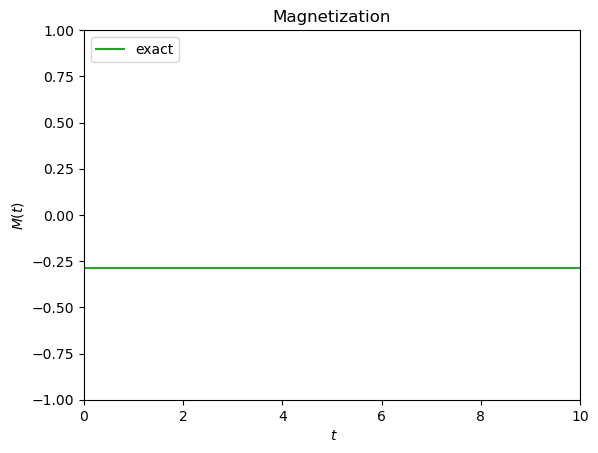

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Parameters
#------------------------------------------
n=5  # spin chain length
#------------------------------------------


# We build the Hamiltonian
#------------------------------------------
sigma_i = np.array([[1, 0], [0, 1]])     # Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])


def kron_N(*args):    
    # Calculate a chain of Kronecker products of a group of matrices.
    result = np.array([[1]], dtype=complex)  # neutral element to start chaining Kronecker products
    for op in args:
        result = np.kron(result, op)
    return result

def H_ising(n):
    # We build the Ising Hamiltonian for n spins
    H = np.zeros((2**n, 2**n), dtype=complex)

    # two-spin terms sum σ^z_i σ^z_{i+1}
    for i in range(n - 1):
        ops = [sigma_i] * n     # creates a list with n copies of the identity matrix
        ops[i] = sigma_z        # replaces the I with Z for couples of contiguous spins
        ops[i + 1] = sigma_z
        H +=  kron_N(*ops) 

    # Transverse field:  sum σ^x_i
    for i in range(n):
        ops = [sigma_i] * n
        ops[i] = sigma_x
        H += kron_N(*ops)

    # Longitudinal field: sum σ^z_i
    for i in range(n):
        ops = [sigma_i] * n
        ops[i] = sigma_z
        H += kron_N(*ops)

    return H

def magnetization_exact(psi, n):
    M = 0  # we are going to store the magnetization here
    for i in range(n):
        ops = [sigma_i]*n
        ops[i] = sigma_z
        Z_i = kron_N(*ops)   # magnetization operator  I x I x ... Z ... x I
        
        # Compute the conjugate transpose of the state
        psi_dagger =   psi.conj().T   # bra 
        # Apply Z_i to the state
        Z_i_psi = np.matmul(Z_i , psi)
        # Take the inner product <psi|Z_i|psi> 
        expectation_value = np.matmul(psi_dagger , Z_i_psi)  # This is a complex scalar (tiny residual imaginary part)
        # Take the real part to ensure we have a physical observable
        expectation_real = np.real(expectation_value)
        # Accumulate into magnetization
        M += expectation_real
    return M/n


# We define the initial state (the ground state of H_ising)
#-------------------------------------------------------------
# We generate four different starting states:
# psi_t0_gs = the ground state
# psi_ts0_up = all spins up
# psi_ts0_down = all spins down
# psi_ts0_random = a random vector
H = H_ising(n)
eigval_t0, eigvecs_t0 = la.eigh(H)    # eigenvalues and eigenstates at t0 
psi_t0_gs = eigvecs_t0[:, 0]  # ground state at t0 (the first state is the ground state, with the lowest eigenvalue, when using eigh, for Hermitian matrices)
# If we use an eigenstate of H_ising as the initial state, the time evolution just provides a phase, so the magnetization will be constant.

#residual = np.linalg.norm(H @ psi_t0_gs - eigval_t0[0] * psi_t0_gs)
#print("Residual norm for ground state eigenvector:", residual)

up = np.array([1, 0], dtype=complex)   # one spin up
psi_t0_up = kron_N(*([up] * n)).reshape(-1)  # all spins up  

down = np.array([0, 1], dtype=complex)   # one spin down
psi_t0_down = kron_N(*([down] * n)).reshape(-1)  # all spins down

def random_initial_state(n):
    dim = 2**n
    # random complex vector: real and imaginary parts from normal distribution
    psi = np.random.randn(dim) + 1j * np.random.randn(dim)
    # normalize
    psi /= np.linalg.norm(psi)
    return psi  
psi_t0_random=random_initial_state(n)

#-------------------------------------------------------------
#psi_t0=psi_t0_up
#psi_t0=psi_t0_down                  # CHOOSE ONE INITIAL STATE FROM HERE
psi_t0=psi_t0_gs             # the ground state of H_ising
#psi_t0=psi_t0_random
#-------------------------------------------------------------
#print("psi_t0:")
#norm = np.linalg.norm(psi_t0)
#print("norm psi_t0=", norm)
#for i, amplitude in enumerate(psi_t0):
#    print(f"|{i:0{n}b}>: {amplitude:.4f}")
#-------------------------------------------------------------
#-------------------------------------------------------------



# Define the evolution operator
#------------------------------------------
def Uev(t,H):
    U = la.expm(-1j*t*H)
    return U

# Define the evolved state of a TD-Hamiltonian
#------------------------------------------
def state_psi(t,psi0,H):
    assert len(psi0) == H.shape[0]
    return np.dot(Uev(t,H),psi0)

# We define a series of time steps to plot M(t)
#-------------------------------------------------
tmin = 0
tmax = 10                         # CHANGE THESE VALUES
steps = 100
#-------------------------------------------------
tlist = np.linspace(tmin, tmax, steps)
psi_t = np.empty((len(tlist), 2**n), dtype=complex)          # here we store the evolved state of the system
magnetization_ex = np.empty((len(tlist)), dtype=float)       # here we store the magnetization for each t value



#and calculate the state at this time
#-------------------------------------------------
for k in range(len(tlist)):
    psi_t[k] = state_psi(tlist[k],psi_t0,H)   # here we evolve psi_t0 to psi_t exponentiating H_ising
    magnetization_ex[k]=magnetization_exact(psi_t[k], n)      # we calculate the magnetization at this point of time
    
#magnetization_ex_real = np.real(magnetization_ex)
#print("mag:",magnetization_ex)  # BORRAR

#print("Type:", type(magnetization_ex))
#print("Shape:", np.shape(magnetization_ex))
#print("dtype:", np.array(magnetization_ex).dtype)

plt.clf()
plt.close()
fig, ax1 = plt.subplots()
ax1.set_title(r'Magnetization')
ax1.set_xlabel(r' $t$ ')
ax1.set_ylabel(r'$M(t)$')
plt.ylim(-1, 1)  # force correct bounds    # THIS IS ABSOLUTELY NEEDED TO AVOID INSANITY WHEN USING THE EIGENVECTOR AS STARTING POINT
#color = 'tab:red'
#print("magnetization_ex at plotting:", magnetization_ex[:10])
ax1.plot(tlist, magnetization_ex, color='tab:green', label='exact')
#ax1.plot(tlist, magnetization_trotter, color='tab:orange', label='Trotterization')
ax1.legend(loc='upper left')
ax1.set_xlim(tmin,tmax)


plt.show()



In [2]:
# Another way to calculate the magnetization, I used to run some tests (I got a crazy behavior of the 
# magnetization when using an eigenvector as initial state, which only got fixed by explicitly stating the
# limits of the y axis in the plot. I still don't understand what was happening there.
import numpy as np
import scipy.linalg as la

n = 5
H = H_ising(n)

#eigval_t0, eigvecs_t0 = la.eigh(H)
#psi_t0_gs = eigvecs_t0[:, 0]

def Uev(t, H):
    return la.expm(-1j * t * H)

def magnetization_exact(psi, n):
    M = 0
    for i in range(n):
        ops = [np.eye(2)] * n
        ops[i] = np.array([[1,0],[0,-1]])  # sigma_z
        Z_i = kron_N(*ops)
        M += np.real(np.vdot(psi, Z_i @ psi))  # <psi|Z_i|psi>
    return M / n

# Test magnetization at t=0 and t=10
t0 = 0
t1 = 10
t2 = 100


M0 = magnetization_exact(psi_t0, n)

psi_t1 = Uev(t1, H) @ psi_t0
M1 = magnetization_exact(psi_t1, n)

psi_t2 = Uev(t2, H) @ psi_t0
M2 = magnetization_exact(psi_t2, n)

print("Magnetization value at some time points:")
print(f"M(t=0) = {M0}")
print(f"M(t=10) = {M1}")
print(f"M(t=100) = {M2}")

Magnetization value at some time points:
M(t=0) = -0.28627787764775914
M(t=10) = -0.2862778776477612
M(t=100) = -0.28627787764778007


Now we take advantage of the k-locality of the Ising Hamiltonian to express it as a sum of local Hermitian terms and use Trotterization instead of matrix exponentiation (diagonalization) to obtain the time evolution of the system.
For this, we will split the Hamiltonian into non-commuting parts that are easier to exponentiate.
$$
H_{\text{Ising}}=\sum_{i=0}^{n-2}\sigma_i^z\sigma_{i+1}^z + \frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^z+\frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^x = H_{ZZ}+ H_{Z} + H_{X}
$$
where
$$
H_{ZZ}=\sum_{i=0}^{n-2}\sigma_i^z\sigma_{i+1}^z  \quad \text{nearest-neighbor ZZ interactions}
$$

$$H_{Z}=\frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^z   \quad \text{transverse field}
$$

$$
H_{X}=\frac{1}{2}\sum_{i=0}^{n-1}\sigma_i^x     \quad  \text{longitudinal field}
$$

The $H_X$ and $H_Z$ are one-body terms and commute within themselves. $H_{ZZ}$ represents a two-body interaction but, since the interaction occurs only between nearest neighbors, we can further split this term in two sets (*odd* and *even*) that don't overlap (non-overlapping terms, commute as well): even terms =  $(0,1), (2,3), (4,5)\cdots$, odd terms = $ (1,2), (3, 4), \cdots$. In the first order Trotter approximation we don't use commuters, so we will just separate the Hamiltonian in three terms.

The first-order Trotter formula:

$$
e^{-iHt}\approx \left(e^{-iH_{ZZ}\delta t } e^{-iH_{Z}\delta t }e^{-iH_{X}\delta t } \right)^N
$$

where $t$ is the evolution time, $N$ is the number of Trotter steps and $\delta t = \frac{t}{N}$ is a small time step. The larger the $N$, the better the approximation.

We want to evolve the initial state $\left|\phi(0)\right>$ to $\left|\phi(t)\right>$ using Trotterization. For this, we will:
1. Define each Hamiltonian term
2. Construct the evolution operations for small time steps
3. Apply them successively to get the evolution of the system
   For $\delta t = 0.1$ , if the target time $t_1=0.1$ , we do one Trotter step $\psi_1=\psi(t_1)=U_{\text{Trotter}}\psi_0$. If  $t_1=0.5$, the number of steps $N$ would be 5 and $\psi_5=\psi(0.5)=U_{\text{Trotter}}^5\psi_0$, if $t_1=5.0$, $N=50$ and $\psi_{50}=\psi(5.0)=U_{\text{Trotter}}^{50}\psi_0$.

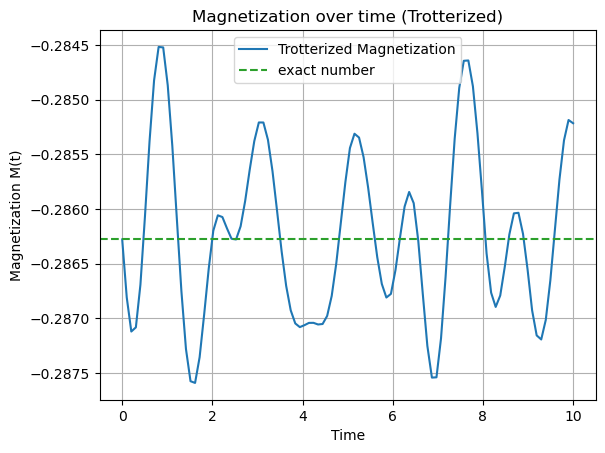

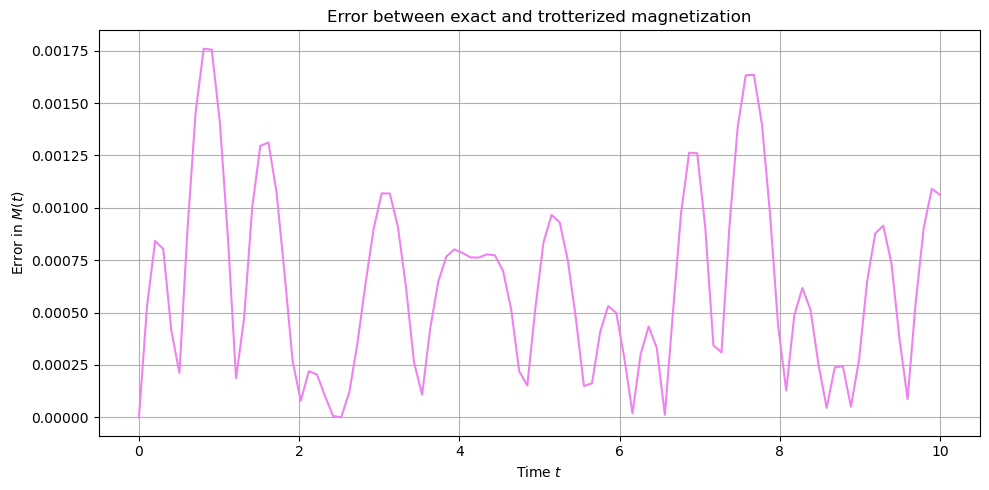

Average error: 0.00063605
Maximum error: 0.00175942


In [3]:
def H_local(n):
    
    Hzz_terms = []
    Hz_terms = []
    Hx_terms = []
    
    for i in range(n):
        ops_z = [sigma_i]*n
        ops_z[i] = sigma_z
        Hz_terms.append(kron_N(*ops_z))  # local Z field on qubit i

        ops_x = [sigma_i]*n
        ops_x[i] = sigma_x
        Hx_terms.append(kron_N(*ops_x))  # local X field on qubit i

    for i in range(n - 1):
        ops = [sigma_i]*n
        ops[i] = sigma_z
        ops[i+1] = sigma_z
        Hzz_terms.append(kron_N(*ops))  # individual terms for Trotter

    return Hzz_terms, Hz_terms, Hx_terms

# We can sum the terms inside Hz_terms and Hx_terms because they
# apply to different spins, so they commute. Not those in Hzz_terms in general.




def trotter_step_operator(Hzz_terms, Hx_terms, Hz_terms, dt):
    U = np.eye(2**n, dtype=complex)

    for H in Hzz_terms:
        U = la.expm(-1j * dt * H) @ U
    for H in Hx_terms:
        U = la.expm(-1j * dt * H) @ U
    for H in Hz_terms:
        U = la.expm(-1j * dt * H) @ U

    return U

# Implements first-order Trotterization:  $$ U_{\text{Trotter}}(\delta t)=\prod_{k}e^{-i\delta tH_k}  $$



# Time evolution using Trotterization
def trotter_evolution0(psi0, Hzz_terms, Hx_terms, Hz_terms, tlist,dt):
    U_step = trotter_step_operator(Hzz_terms, Hx_terms, Hz_terms, dt)

    psi_t = []
    psi = psi0.copy()                   
    for _ in tlist:
        psi_t.append(psi)
        psi = U_step @ psi  # apply one Trotter step

    return np.array(psi_t)



def trotter_evolution_new(psi0, Hzz_terms, Hx_terms, Hz_terms, tlist, delta_t):
    """
    Evolve psi0 using first-order Trotterization for H = Hzz + Hx + Hz.
    delta_t is the fixed Trotter time step.
    For each time t in tlist, we compute psi(t) by applying (U_step)^N where N = int(t / delta_t)
    """
    dim = psi0.shape[0]
    psi_t = []

    # Precompute the single Trotter step operator
    U_step = trotter_step_operator(Hzz_terms, Hx_terms, Hz_terms, delta_t)

    for t in tlist:
        Nmini = int(t / delta_t)  # number of Trotter steps to reach time t
        psi = psi0.copy()
        for _ in range(Nmini):
            psi = U_step @ psi
        psi_t.append(psi)

    return np.array(psi_t)




# Obtains the expectation value of the magnetization
def magnetization(psi, n):
    M = 0
    for i in range(n):
        ops = [sigma_i] * n
        ops[i] = sigma_z
        Z_i = kron_N(*ops)
        M += np.real(np.vdot(psi, Z_i @ psi))
    return M / n

# We run the code
#----------------------------------------------
n = 5
tmin = 0
tmax = 10     # total simulation time
steps = 100    # steps where the magnetization is sampled

# observable output time grid
tlist = np.linspace(tmin, tmax, steps)  # t_i times at which we record psi_t, magnetization, etc.
                    # it does not influence the evolution itself. The evolution happens at a finer
                    # resolution via delta_t

# Trotter discretization
N_trotter_steps = 1000    # number of evolution steps
delta_t = tmax / N_trotter_steps   #   time interval per Trotter step



# Choose an initial state (e.g., ground state or all spins up)
psi0=psi_t0.copy()


# Build local terms
Hzz_terms, Hx_terms, Hz_terms = H_local(n)

# Evolve using Trotterization
psi_trotter = trotter_evolution_new(psi0, Hzz_terms, Hx_terms, Hz_terms, tlist,delta_t)

# Compute magnetization
magnetization_trotter = np.array([magnetization(psi_t, n) for psi_t in psi_trotter])

import matplotlib.pyplot as plt

plt.plot(tlist, magnetization_trotter, label="Trotterized Magnetization")
plt.axhline(y=-0.28627788, color='tab:green', linestyle='--', label=f'exact number')
plt.xlabel("Time")
plt.ylabel("Magnetization M(t)")
plt.title("Magnetization over time (Trotterized)")
plt.grid(True)
plt.legend()
plt.show()


# And now we calculate and plot the deviation between the exact 
# magnetization and that obtained with trotterization
#-------------------------------------------------------
#error = np.abs(magnetization_trotter +0.28627788)
error = np.abs(magnetization_trotter - magnetization_ex)
plt.figure(figsize=(10,5))
plt.plot(tlist, error, color='violet')
plt.xlabel('Time $t$')
plt.ylabel('Error in $M(t)$')
plt.title('Error between exact and trotterized magnetization')
plt.grid(True)
plt.tight_layout()
plt.show()


# Average error
avg_error = np.mean(error)

# Maximum error
max_error = np.max(error)

print(f"Average error: {avg_error:.8f}")
print(f"Maximum error: {max_error:.8f}")


With all these functions, we evaluate the magnetization of the ground state of the Ising Hamiltonian through direct evolution (*exact*) and using the Trotter approximation with different number of steps $N$ (*trotter*).

list of N values: (50, 100, 1000, 10000)


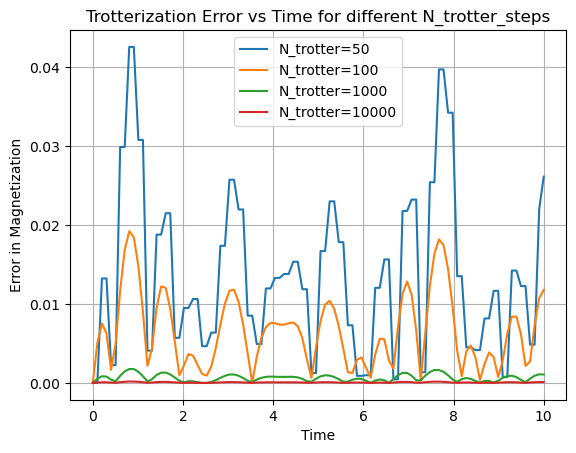

list of N values: (10000, 50000, 100000)


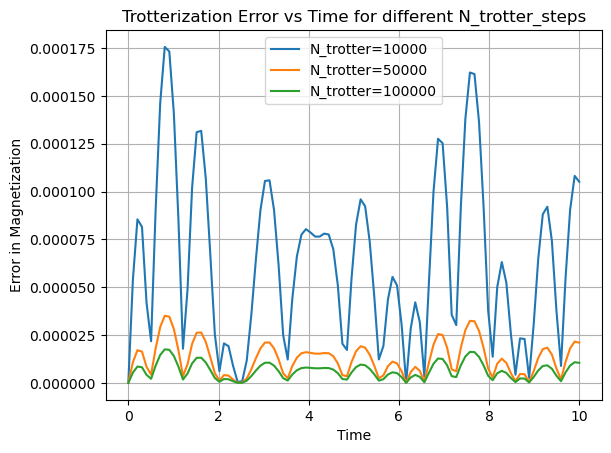

In [20]:
def trotter_whole(n,tmin,tmax,steps,N_trotter_steps):
    #n = 5
    #tmin = 0
    #tmax = 10     # total simulation time
    #steps = 100    # number of steps where to sample M(t) and psi(t)
    tlist = np.linspace(tmin, tmax, steps)  
    
    # Trotter discretization
    delta_t = tmax / N_trotter_steps   #   time interval per Trotter step
    # Choose an initial state
    psi0=psi_t0.copy()    # we use the same defined at the beginning of the code
    # Build local terms
    Hzz_terms, Hx_terms, Hz_terms = H_local(n)
    # Evolve using Trotterization
    psi_trotter = trotter_evolution_new(psi0, Hzz_terms, Hx_terms, Hz_terms, tlist,delta_t)
    # Compute magnetization
    magnetization_trotter = np.array([magnetization(psi_t, n) for psi_t in psi_trotter])
    
    return tlist, magnetization_trotter
    
# We run the program
#-----------------------------------
n = 5
tmin = 0
tmax = 10     # total simulation time
steps = 100    # steps where the magnetization is sampled

N_trotter_steps_min=1
N_trotter_steps_max=10000
#num_values=6
#trotter_steps_list = np.geomspace(
#    N_trotter_steps_min,
#    N_trotter_steps_max,
#    num=num_values,
#    dtype=int
#    )
trotter_steps_list=(50,100,1000,10000)
print("list of N values:",trotter_steps_list)

results = {}   # dictionnary to store the results
for i in (range(len(trotter_steps_list))):
    tlist, mag_t = trotter_whole(n,tmin,tmax,steps,trotter_steps_list[i])
    results[trotter_steps_list[i]]=(tlist,mag_t)  # a dictionnary with the results
    

for N, (tlist, mag_t) in results.items():
    error = np.abs(mag_t - magnetization_ex)
    plt.plot(tlist, error, label=f'N_trotter={N}')
    
plt.xlabel('Time')
plt.ylabel('Error in Magnetization')
plt.title('Trotterization Error vs Time for different N_trotter_steps')
plt.legend()
plt.grid(True)
plt.show()


# Another run
#-------------------------------------------
trotter_steps_list=(10000,50000,100000)
print("list of N values:",trotter_steps_list)

results = {}   # dictionnary to store the results
for i in (range(len(trotter_steps_list))):
    tlist, mag_t = trotter_whole(n,tmin,tmax,steps,trotter_steps_list[i])
    results[trotter_steps_list[i]]=(tlist,mag_t)  # a dictionnary with the results
    

for N, (tlist, mag_t) in results.items():
    error = np.abs(mag_t - magnetization_ex)
    plt.plot(tlist, error, label=f'N_trotter={N}')
    
plt.xlabel('Time')
plt.ylabel('Error in Magnetization')
plt.title('Trotterization Error vs Time for different N_trotter_steps')
plt.legend()
plt.grid(True)
plt.show()

We generate a table with the average error so that we can more easily analyze the relationship between $N$ and $\varepsilon$:


In [27]:
# Last run
#-------------------------------------------
trotter_steps_list=(10,10,100,1000,10000,100000,1000000,10000000)
#trotter_steps_list=(10,10,100,1000)
print("list of N values:",trotter_steps_list)

results = {}   # dictionnary to store the results
for i in (range(len(trotter_steps_list))):
    tlist, mag_t = trotter_whole(n,tmin,tmax,steps,trotter_steps_list[i])
    results[trotter_steps_list[i]]=(tlist,mag_t)  # a dictionnary with the results
    
print("Average error in M(t) between the Trotter approximation and the exact time evolution")
print("Fixed value of t=10")
print(f"{'N':<15}{'Average Error':<20}{'N*Error':<20}")
print("-" * 50)
for N, (tlist, mag_t) in results.items():
    error = np.abs(mag_t - magnetization_ex)
    average_error = np.mean(error)
    print(f"{N:<15}{average_error:<20.6e}{average_error*N:<20.6e}")


list of N values: (10, 10, 100, 1000, 10000, 100000, 1000000, 10000000)
Average error in M(t) between the Trotter approximation and the exact time evolution
Fixed value of t=10
N              Average Error       N*Error             
--------------------------------------------------
10             2.788079e-01        2.788079e+00        
100            6.540299e-03        6.540299e-01        
1000           6.360513e-04        6.360513e-01        
10000          6.356246e-05        6.356246e-01        
100000         6.355776e-06        6.355776e-01        
1000000        6.355774e-07        6.355774e-01        
10000000       6.358851e-08        6.358851e-01        


With this, we confirm that the error scales with $1/N$.
We will use the same scheme now to analyze the dependence on $t$.

In [40]:
# Last run
#-------------------------------------------
#trotter_steps_list=(10,10,100,1000,10000,100000,1000000,10000000)
trotter_step=1000000
tmax_list=(1,10,25, 50,100,500,1000)
print("list of t values:",tmax_list)

results = {}   # dictionnary to store the results
for i in (range(len(tmax_list))):
    tlist, mag_t = trotter_whole(n,tmin,tmax_list[i],steps,trotter_step)
    results[tmax_list[i]]=(tlist,mag_t)  # a dictionnary with the results
    
print("Average error in M(t) between the Trotter approximation and the exact time evolution")
print("Fixed value of N=100000")
print(f"{'tmax':<15}{'Average Error':<20}{'error*N/tmax**2':<20}")
print("-" * 50)
for tmax, (tlist, mag_t) in results.items():
    error = np.abs(mag_t +0.28627788)   # I use this value instead of using the exact magnetization 
                        # calculated previously so as not to have to re-run the calculation 
                        # for different values of t_max
    average_error = np.mean(error)
    print(f"{tmax:<15}{average_error:<20.6e}{(N*average_error)/tmax**2:<20.6e}")


list of t values: (1, 10, 25, 50, 100, 500, 1000)
Average error in M(t) between the Trotter approximation and the exact time evolution
Fixed value of N=100000
tmax           Average Error       error*N/tmax**2     
--------------------------------------------------
1              9.413476e-08        9.413476e-01        
10             6.355774e-07        6.355774e-02        
25             1.398269e-06        2.237231e-02        
50             2.697023e-06        1.078809e-02        
100            5.977638e-06        5.977638e-03        
500            3.208540e-05        1.283416e-03        
1000           5.551608e-05        5.551608e-04        


The dependency on $t^2$ is not that clear from this table, although it approximately holds in a certain range. 